<a href="https://colab.research.google.com/github/jx-dohwan/Natural-Language-Processing-using-Transformers/blob/main/CH8_efficient_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 효율적인 트랜스포머 구축
- 애플리케이션에 대한 비즈니스 요구사항을 만족시키기에 모델이 너무 느리거나 크다면 최고 성능의 모델이라도 유용하지 않다.
- 당연히 그 대안은 빠르고 작은 모델을 훈련하는 것이다.
- 하지만 모델 용량을 줄이면 종종 성능이 저하된다. 
- 그럼 빠르고 작지만 정확도가 높은 모델이 필요할 땐 어떻게 해야할까?
- 예측 속도를 높이고, 트랜스포머 모델의 메모리 사용량을 줄이는 네 가지 기술
    - 지식 전제(knowledge distillation)
    - 양자화(quantization)
    - 가지치기(pruning)
    - ONNX(open Neural Network Exchange) 포맷과 ONNX 런타임(ORT)을 사용한 그래프 최적화(graph optimization)
- 추가로 이런 기술을 연결해 성능을 크게 향상하는 방법도 알아보겠다.
- 로블록스 엔지니얼이 팀은 블로그 포스트에서 이런 방법을 소개했다.
- 이 팀은 지식 정제와 양자화를 연결해 레이턴시와 BERT 분류기의 처리 성능을 30배 이상 향상했다.



- 각 기술의 장단점을 이해하기 위해 의도 탐지(intent detection) 예제를 들겠다.
- 의도 탐지는 텍스트 기반 어시스턴트(assistant) 시스템에서 중요한 구성 요소
- 여기서 실시간 대화를 유지하려면 레이턴시가 낮아야 한다.
- 이를 통해 사용자 정의 트레이너를 만드는 방법, 효율적으로 하이퍼파라미터 검색을 수행하는 방법을 배우겠다.
- 또 트랜스포머로 최신 연구를 구현하는 데 필요한 사항을 알아보겠다.

In [1]:
# 코랩이나 캐글을 사용한다면 이 셀의 주석을 제거하고 실행하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=8)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 538, done.
remote: Counting objects: 100% (272/272), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 538 (delta 165), reused 184 (delta 107), pack-reused 266
Receiving objects: 100% (538/538), 46.22 MiB | 13.08 MiB/s, done.
Resolving deltas: 100% (264/264), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.25.1
Using datasets v2.8.0
Using accelerate v0.15.0
Using optuna v3.1.0
Using onnxruntime v1.13.1
Using onnx v1.13.0


## 1. 의도 탐지 예제
- 고객의 목적을 이해하기 위해 다양한 자연어 텍스트를 사전에 정의된 일련의 행동이나 의도로 분류해야한다.
- 고객이 사전에 정의된 의도에 속하지 않은 쿼리를 제공하면 시스템은 대체 응답을 출력해야한다.

In [2]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

Downloading:   0%|          | 0.00/8.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [3]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in 
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490036010742188}]

## 2. 벤치마크 클래스 만들기
- 제품 환경에 배포하려면 여러가지 제약 조건을 절출해야한다.
    - 모델 성능
         - 제품 환경의 데이터를 반영하는 잘 준비된 테스트 세트에서 모델은 얼마나 잘 작동할까
         - 모델 성능은 특히 오류가 발생했을 때 손실 비용이 큰 상황이나(또는 오류 발생을 줄이기 위헤ㅐ 사람이 참여하는 것이 최선일 때)
         - 수백만 개의 샘플에서 추론을 실행해야 하므로 모델 지표가 조금 향상되면 젙체적으로 큰 이득을 얻을 수 있는 상황에서 중요합니다.
    - 레이턴시
        - 모델이 얼마나 빠르게 예측을 만드나요?
        - 레이턴시는 보통 대량의 트래픽을 처리하는 실시간 환경에서 고려한다.
        - 예를 들면, 스택 오버플로는 웹사이트에서 부적절한 댓글을 빠르게 감지하는 분류기가 필요하다.
    - 메모리
        - GPT-2나 T5처럼 파라미터가 십업 개가 돼서 기가바이트 단위의 디스크와 램이 필요한 모델은 어떻게 배포할까?
        - 메모리는 모바일과 에지 장치에서 특별히 중요한 역할을 수행한다.
        - 이 환경에서는 모델이 강력한 클라우드 서버에 접속하지 않고 예측을 만들어야 한다.
 
 
> 다양한 압축 기법으로 최적화 하는 방법을 알아보기 위해 먼저 파이프라인과 테스트 세트가 주어지면 성능을 측정하는 간단한 벤치마크 클래스를 만들겠다.

In [4]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type
        
    def compute_accuracy(self):
        # 나중에 정의합니다
        pass    

    def compute_size(self):
        # 나중에 정의합니다
        pass

    def time_pipeline(self):
        # 나중에 정의합니다
        pass
    
    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

- 이 장에서 다룰 여러 가지 최적화 기법의 성능을 추적하기 위해 optim_type 매개변수를 정의했다.
- run_benchmark() 메서드를 사용해 딕셔너리에 optim_type을 키로 모든 지표를 저장한다.

In [5]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")

Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

Dataset clinc_oos downloaded and prepared to /root/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

- 여기에서 plus 설정은 범위 밖의 훈련 샘플이 담긴 서브셋을 의미한다.
- CLINC150의 각 샘플은 text 열에 있는 쿼리와 이에 상응하는 의도로 구성됐다.

In [6]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [7]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

In [8]:
from datasets import load_metric 

accuracy_score = load_metric("accuracy")

<ipython-input-8-2ddb94fb810d>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric("accuracy")


- 정확도 지표는 정수로 표현된 예측과 참조(즉, 정답 레이블)를 기대합니다.
- 이를 위해 파이프라인을 사용해 text 필드에서 예측을 추출하고, 
- intents 객체의 str2int() 메서드를 사용해 각 예측을 해당 ID로 매핑한다.
- 다음 코드는 데이터셋의 모든 예측과 레이블을 리스트로 취합한 후 정확도를 계산해 반환한다.
- 이 메서드를 PerformanceBenchmark 클래스에 추가하겠다.

In [9]:
def compute_accuracy(self):
    """PerformanceBenchmark.compute_accuracy() 메서드를 오버라이드합니다"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"테스트 세트 정확도 - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

In [10]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.weight',
 tensor([[-1.0526e-02, -3.2215e-02,  2.2097e-02,  ..., -6.0953e-03,
           4.6521e-03,  2.9844e-02],
         [-1.4964e-02, -1.0915e-02,  5.2396e-04,  ...,  3.2047e-05,
          -2.6890e-02, -2.1943e-02],
         [-2.9640e-02, -3.7842e-03, -1.2582e-02,  ..., -1.0917e-02,
           3.1152e-02, -9.7786e-03],
         ...,
         [-1.5116e-02, -3.3226e-02,  4.2063e-02,  ..., -5.2652e-03,
           1.1093e-02,  2.9703e-03],
         [-3.6809e-02,  5.6848e-02, -2.6544e-02,  ..., -4.0114e-02,
           6.7487e-03,  1.0511e-03],
         [-2.4961e-02,  1.4747e-03, -5.4271e-02,  ...,  2.0004e-02,
           2.3981e-02, -4.2880e-02]]))

- 그 다음 파이토치의 torch.save() 함수를 사용해 모델을 디스크에 직렬화하고 크기를 계산해보자
- 내부적으로 torch.save()는 파이썬의 pickle 모듈을 사용하며, 모델을 비룻해 텐서, 일반적인 파이썬 객체까지 그 어떤 것도 저장할 수 있다.
- 파이토치에서는 모델을 저장할 때 state_dict() 메서드를 사용하길 추천합니다.
- 이 메서드는 모델의 층과 학습 가능한 파라미터(즉, 가중치와 편향)를 매핑하는 파이썬 딕셔너리를 반환합니다.
- 기준 모델의 state_dict() 메서드가 반환한 내용을 확인해보자

In [11]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.weight',
 tensor([[-1.0526e-02, -3.2215e-02,  2.2097e-02,  ..., -6.0953e-03,
           4.6521e-03,  2.9844e-02],
         [-1.4964e-02, -1.0915e-02,  5.2396e-04,  ...,  3.2047e-05,
          -2.6890e-02, -2.1943e-02],
         [-2.9640e-02, -3.7842e-03, -1.2582e-02,  ..., -1.0917e-02,
           3.1152e-02, -9.7786e-03],
         ...,
         [-1.5116e-02, -3.3226e-02,  4.2063e-02,  ..., -5.2652e-03,
           1.1093e-02,  2.9703e-03],
         [-3.6809e-02,  5.6848e-02, -2.6544e-02,  ..., -4.0114e-02,
           6.7487e-03,  1.0511e-03],
         [-2.4961e-02,  1.4747e-03, -5.4271e-02,  ...,  2.0004e-02,
           2.3981e-02, -4.2880e-02]]))

- 각각의 키/값 쌍이 BERT의 층과 텐서에 해당된다.
- 따라서 모델은 다음고과 같은 방식으로 저장한다.

In [12]:
#torch.save(pipe.model.state_dict(), 'model.pt')

- 그 다음 파이썬의 pathlib 모듈의 Path.stat() 함수를 사용해 저장된 파일의 정볼르 얻습니다.
- 특히 Path("model.pt").stat().st_size에는 모델 크기가 바이트 단위로 저장됐습니다.
- 이런 정보를 모두 사용해 compute_size() 함수를 만들고 PerformanceBenchmark 클래스에 추가하겠습니다.

In [14]:
import torch
from pathlib import Path

def compute_size(self):
    """PerformanceBenchmark.compute_size() 메서드를 오버라이드합니다"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # 메가바이트 단위로 크기를 계산합니다
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # 임시 파일을 삭제합니다
    tmp_path.unlink()
    print(f"모델 크기 (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

- 마지막으로 쿼리마다 평균적인 레이턴시를 재기 위해 time_pipeline() 함수를 구현하겠다.
- 이 애플리케이션에서 레이턴시는 파이프라인에 텍스트 쿼리를 주입하고 모델로부터 예측된 의도가 반환되기 까지 걸린 시간을 의미한다.
- 파이프라인은 내부적으로 텍스트를 토큰화하지만 이 작업은 예측을 생성하는 것보다 천 배 가량 더 빠르다.
- 따라서 전체적인 레이턴시에 미치는 영향을 무시해도 무방하다.
- 코드 실행 시간을 측정하는 간단한 방법은 파이썬의 time 모델이 제공하는 perf_counter() 함수를 사용하는 것이다.
- 이 함수를 time.time()함수보다 더 미세한 수준으로 시간을 측정해 정밀한 결과를 요하는 곳에 적합하다.

> 파이프라인에 테스트 쿼리를 전달하고 perf_counter()를 사용해 코드 실행의 시작과 끝 시간 차이를 밀리초 단위로 계산하겠습니다.

In [15]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"레이턴시 (ms) - {1000 * latency:.3f}")

레이턴시 (ms) - 102.525
레이턴시 (ms) - 93.007
레이턴시 (ms) - 96.181


- 결과를 보면 레이턴시 차이가 크다.
- 파이프라인의 1회 실생 시간을 재보면 코드를 실행할 때마다 결과가 달라진다.
- 그러므로 파이프라인을 여러 번 실행해 레이턴시를 수집하고 그 결과의 평균과 표준편차를 계산한 후, 분포를 구해 값이 얼마나 퍼져 있는지 파악해야 한다.
- 다음 코드에는 실제 실행을 수행하기 전에 CPU를 워밍업 하는 단계가 포함됐다.

In [16]:
import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
    """PerformanceBenchmark.time_pipeline() 메서드를 오버라이드합니다d"""
    latencies = []
    # 워밍업
    for _ in range(10):
        _ = self.pipeline(query)
    # 실행 측정
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # 통게 계산
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"평균 레이턴시 (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

In [17]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

모델 크기 (MB) - 418.15
평균 레이턴시 (ms) - 63.16 +\- 11.38
테스트 세트 정확도 - 0.867


## 3. 지식 정제로 모델 크기 줄이기
- 작은 스튜던트 모델을 훈련하는 방법으로, 느리고 크지만 성능이 더 높은 티처의 동작을 모방하도록 작은 스튜던트 모델을 훈련한다.
- 지식정제는 앙상블 모델을 위해 2006년에 처음 소개 됐다
- 2015년에 발표된 유명한 논문에서 심층 신경망에 이 방법을 일반화해 이미지 분류와 자동 음성 인식에 적용하면서 널리 알려졌다.
- 사전 훈련하는 언어 모델의 파라미터 개수가 꾸준히 증가하는 경향을 고려할때
- 지식 정제는 대규모 모델을 압축해 실용적인 애플리케이션 구축에 적합하게 만드는 인기있는 전략이다.

### 1) 미세 튜닝에서의 지식 정제
- 훈련하는 동안 지식은 어떻게 정제되고 티쳐에서 스튜던트로 전달될까?
- 미세튜닝 같은 지도 학습 작업에서는 티처의 소프트 확률로 정답 레이블을 보강해서 스튜던트가 학습할 때 부가 정보를 제공하는 것이 주요 아이디어이다
- 예를 들어 bert 기반 분류기가 여러 개의 의도에 높은 확률을 할당한다면, 이 의도는 특성 공간 안에서 서로 가까이 위치한다는 신호일 가능성이 있다.
- 이런 확률을 모방하도록 스튜던트 훈련해서 티처가 학습한 검은 지식을 정제한다.
- 검은 지식이란 레이블만으로는 얻지 못하는 지식이다.


- 수학적으로는 입력 시퀀스 X를 티처에 전달해 로짓 벡터를 생성한다. 이 로짓에 소프트맥스 함수를 적용하면 확률로 변환된다.
- 하지만 많은 경우, 티처가 한 클래스에 높은 확률을 할당해서 나머지 클래스 확률이 0에 가까워지며 이는 우리가 원하는 바가 아니다.
- 이 경우 티처는 정답 레이블 외에 추가 정보를 많이 제공하지 않습니다.
- 따라서 소프트맥스 함수를 적용하기 전에 온도 하이퍼파라미터 T로로짓의 스케일을 조정해 확률을 소프트하게 만들어야 한다


- 위의 그림에 있듯이 높은 T값은 클래스에 대해 완만한 확률 분포를 만든다.
- 티처가 각 훈련 샘플로부터 학습한 결정 경계에 대한 정보가 더 많이 드러난다.
- T=1이면 원래 소프트맥스 함수의 분포가 된다.



...

### 2) 사전 훈련에서의 지식 정제
- 사전 훈련하는 동안 후속 작업에서 미세 튜닝이 가능한 범용 스튜던트를 만들기 위해 지식 정제를 사용할 수도 있습니다.
- 이 경우 티처는 마스크드 언어 모델링의 지식을 스튜던트에 전달하는 BERT 같은 사전 훈련된 언어 모델입니다.
- 예를 들어 DistiBERT 논문에서 마스크드 언어 모델링 손실은 지식 정제 항과 티처와 스튜던트 간의 은닉 상태 벡터의 방향을 정렬하기 위해 코사인 임베딩 손실로 보강됩니다.
- 이미 미세튜닝된 BERT 기반 모델이 있으므로, 지식 정제를 사용해 더 작고 빠른 모델을 미세튜닝하는 방법을 알아보겠습니다.
- 이를 위해 크로스 엔트로피 손실에 Lkd 항을 추가해야 합니다
- 다행히 사용자 정의 트레이너를 만들어 추가하는 방법이 있다.


### 3) 지식 정제 트레이너 만들기
지식 정제를 구현하기 위해 Trainer 클래스에 몇 가지를 추가해야한다.
- 새로운 하이퍼파라미터 α와 T입니다. α는 정제 손실의 상대적인 가중치를 제어합니다. T는 레이블의 확률 분포를 얼마나 완만하게 만들지 조절합니다.
- 미세튜닝한 티처 모델, 여기서는 BERT 베이스입니다.
- 크로스 엔트로피와 지식 정제 손실을 연결한 새로운 손실 함수

새로운 하이퍼파라미터를 추가하는 방법은 매우 간단하다 TrainingArguments 클래스를 상속해 새로운 속성을 추가하면 된다.

In [18]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

- 트레이너 자체적으로는 새로운 손실 함수가 필요하다 Trainer 클래스를 상속하고 지식 정제 손실 항 Lkd을 추가하기 위해 compute_loss() 메서드를 오버라이딩 하면 구현 가능하다

In [19]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = inputs.to(device)
        outputs_stu = model(**inputs)
        # 스튜던트의 크로스 엔트로피 손실과 로짓을 추출합니다
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # 티처의 로짓을 추출합니다
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # 확률을 부드럽게하고 정제 손실을 계산합니다
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # 가중 평균된 스튜던트 손실을 반환합니다
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

- DistillationTrainer 클래스의 객체를 만들 때 이 작업에서 이미 미세 튜닝된 티처를 teacher_model 매개변수에 전달한다.
- 그 다음 compute_loss() 메서드에서 스튜던트와 티처의 로짓을 추출하고, 온도로 스케일링을 조정하고
- 그 다음 소프트맥스로 정규화한 후 파이토치 nn.KLDivLoss() 함수에 전달해서 KL 발산을 계산해야 한다.
- nn.KLDivLoss()에서 입력은 로그 확률로, 레이블은 일반 확률로 기대한다는 점이 특이하다
- 이 때문에 F.log_softmax()를 사용해 스튜던트 로짓을 정규화하고 티처 로짓은 표준 소프트맥스 함수를 사용해 확률로 변환합니다.
- nn.KLDiLoss()의 reduction="batchmean" 매개변수는 배치 차원에서 손실을 평균합니다.

### 4) 좋은 스튜던트 선택하기
- 보통 레이턴시와 메모리 사용량을 줄이기 위해 스튜던트로 작은 모델을 골라야 한다.
- 논문에 사용된 경험 법칙에 의하면 티처와 스튜던트가 동일한 종류의 모델일 때 지식 정제가 잘 동작한다.
- 이에 대한 이유 중 하나는 가량 BERT와 RoBERTa처럼 모델 종류가 다를 때 출력 임베딩 공간이 달라서 스튜던트가 티처를 모방하는 데 방해가 되기 때문이다. 
- 여기서는 티처가 BERT이므로 DistilBERT가 자연스럽게 스튜던트 후보가 된다.
- DistilBERT는 파라미터가 40% 더 적고 후속 작업에서 좋은 결과를 낸다고 알려져 있다.


- 먼저 쿼리를 토큰화하고 인코딩한다.
- 따라서 DistilBERT의 토크나이저를 초기화하고 간단하게 전처리를 수행할 tokenize_text() 함수를 만들겠다.

In [20]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

- text 열은 더 이상 필요하지 않기 때문에 삭제했다.
- 또 트레이너가 자동으로 감지하도록 intent 열을 labels로 바꿨다.


- 텍스트를 처리했으니 다음에는 하이퍼파라미터와 DistillationTrainer 클래스를 위해 compute_metrics() 함수를 정의한다.
- 모델은 모두 허깅페이스 허브에 저장할 것이다.
- 그러나 지금 개발 환경은 캐글 노트북이다. huggingface_hub에 로그인을 할 수가 없는 상태이다.

In [29]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [30]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

- 이 함수에서 시퀀스 모델링 헤드가 출력한 예측은 로짓의 형태이다.
- 따라서 np.argmax() 함수를 사용해 확률이 가장 높은 클래스를 찾고 정답 레이블과 비교한다.


- 그 다음 훈련 매개변수를 정의한다.
- 처음에는 α=1로 지정해 티처로부터 어떤 신호도 받지 않고 DistilBERT의 성능이 얼마나 나오는지 보겠다.
- 미세튜닝된 모델을 Distilbert-base-uncased-finetuned-clinc 저장소에 업로드 하기 위해 DistillationTrainingArguments의 output_dir 매개변수에 이를 저장한다.

In [31]:
batch_size = 24

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, evaluation_strategy = "epoch", 
    num_train_epochs=5, learning_rate=2e-5, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01, 
    push_to_hub=True)

In [32]:
student_training_args.logging_steps = len(clinc_enc['train']) // batch_size
student_training_args.disable_tqdm = False
student_training_args.save_steps = 1e9
# 트랜스포머 4.23.0 버전부터 로깅 수준을 문자열로 지정해야 합니다.
# student_training_args.log_level = 40
student_training_args.log_level = 'error'

In [33]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


- 에포크 횟수, 가중치 감쇠, 학습률 같은 몇 개의 하이퍼파라미터 기본값을 바꿨다.
- 다음으로 스튜던트 모델을 만든다.
- 트레이너로 여러 번 실행할 것이므로, 실행 시마다 모델을 초기화하는 student_init()함수를 만들겠다.
- 이 함수를 DistillationTrainer에 전달하면 train() 메서드가 호출될 때마다 새 모델이 만들어 진다.

또 스튜던트 모델에 의도와 레이블 ID의 매핑을 제공해야 한다. 파이프라인에서 다운로드한 BERT 베이스 모델에서 이런 매핑을 얻는다.

In [34]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

- 이 매핑과 함께 AutoConfig 클래스를 사용해 사용자 정의 모델 설정을 만든다.
- 그럼 레이블 매핑에 관한 정보를 사용해 스튜던트를 위한 설정을 만들어 보자

In [35]:
from transformers import AutoConfig

num_labels = intents.num_classes
student_config = (AutoConfig.from_pretrained(student_ckpt, num_labels=num_labels, 
                                            id2label=id2label, label2id=label2id))

- 모델이 기대해야할 클래스 개수도 지정했다.
- 이 설정을 AutoModelForSequenceClassification 클래스의 from_pretrained() 함수에 전달한다.

In [36]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification.from_pretrained(
        student_ckpt, config=student_config).to(device))

In [37]:

teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [38]:
distilbert_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distilbert_trainer.train()

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/huggingface_hub/repository.py:725: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.12. Please create the repository first using `create_repo(..., exists_ok=True)`.
  warnings.warn(
Cloning https://huggingface.co/jx7789/distilbert-base-uncased-finetuned-clinc into local empty directory.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


TrainOutput(global_step=3180, training_loss=1.308894199470304, metrics={'train_runtime': 320.3807, 'train_samples_per_second': 237.998, 'train_steps_per_second': 9.926, 'total_flos': 380989311528840.0, 'train_loss': 1.308894199470304, 'epoch': 5.0})

In [39]:
distilbert_trainer.push_to_hub("Training completed!")

Upload file pytorch_model.bin:   0%|          | 32.0k/256M [00:00<?, ?B/s]

Upload file runs/Jan19_08-14-06_03b6cf621b22/events.out.tfevents.1674116069.03b6cf621b22.3559.0: 100%|########…

Upload file runs/Jan19_08-14-06_03b6cf621b22/1674116069.1719682/events.out.tfevents.1674116069.03b6cf621b22.35…

Upload file training_args.bin: 100%|##########| 3.43k/3.43k [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/jx7789/distilbert-base-uncased-finetuned-clinc
   9d99ac8..8a60a4a  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/jx7789/distilbert-base-uncased-finetuned-clinc
   9d99ac8..8a60a4a  main -> main

To https://huggingface.co/jx7789/distilbert-base-uncased-finetuned-clinc
   8a60a4a..30d7056  main -> main

   8a60a4a..30d7056  main -> main



'https://huggingface.co/jx7789/distilbert-base-uncased-finetuned-clinc/commit/8a60a4a1379b4cf2b3b19faf2ad508df58f031cf'

In [40]:
# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
finetuned_ckpt = "jx7789/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

Downloading:   0%|          | 0.00/8.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/360 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/711k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [41]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 255.88
평균 레이턴시 (ms) - 38.76 +\- 8.76
테스트 세트 정확도 - 0.883


- 결과를 기존 모델과 비교하기 위해 레이턴시와 정확도를 사용해 산점도를 그려보겠다.
- 각 포인트의 반지름은 디스크에 저장된 모델의 크기에 해당한다.
- 다음 함수는 이런 작업을 처리하며
- 이전 결과와 쉽게 비교하도록 현재 최적화 방법의 결과를 점선으로 표시한다.

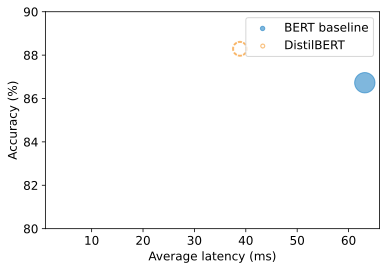

In [42]:
import pandas as pd

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # 현재 최적화 방법을 점선으로 그립니다
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        alpha=0.5, s=df_opt["size_mb"], label=idx, 
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        s=df_opt["size_mb"], label=idx, alpha=0.5)
            
    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # 가장 느린 모델을 사용해 x 축 범위를 정합니다
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()
    
plot_metrics(perf_metrics, optim_type)

### 5) 옵투나로 좋은 하이퍼파라미터 찾기
- 좋은 α와 T 값을 찾기 위해 2D 하이퍼파라미터 공간에서 그리디 서치를 수행할 수 있습니다.
- 하지만 이런 작업을 위해 설계된 최적화 프레임워크 옵투나를 사용하는 방법이 더 좋습니다.
- 옵투나는 검색 문제를 여러 시도를 통해 최적화할 목적 함수로 표현합니다. 


In [43]:
def objective(trial):
  x = trial.suggest_float('x', -2, 2)
  y = trial.suggest_float('y', -2, 2)
  return (1 - x) ** 2 + 100 * (y-x**2)**2

- trial.suggest_float() 메서드는 균등하게 샘플링할 파라미터 범위를 지정합니다.
- 옵투나는 정수와 범주형 파라미터를 위해 각각 suggest_int와 suggest_categorical도 제공합니다.
- 옵투나는 여러 시도를 하나의 스터디로 수집하므로 다음처럼 objective() 함수를 study.optimize() 메서드에 전달합니다.

In [44]:
import optuna

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2023-01-19 08:41:28,829] A new study created in memory with name: no-name-d1f82de4-d72e-4d52-971d-b4230eed354f
[I 2023-01-19 08:41:28,836] Trial 0 finished with value: 312.5498058840955 and parameters: {'x': -0.1414869645652308, 'y': 1.7842374063927298}. Best is trial 0 with value: 312.5498058840955.
[I 2023-01-19 08:41:28,838] Trial 1 finished with value: 193.2734070557142 and parameters: {'x': 0.8233080975116418, 'y': -0.7122795524239351}. Best is trial 1 with value: 193.2734070557142.
[I 2023-01-19 08:41:28,841] Trial 2 finished with value: 12.849698768250141 and parameters: {'x': 1.1920791348429414, 'y': 1.779002441967918}. Best is trial 2 with value: 12.849698768250141.
[I 2023-01-19 08:41:28,849] Trial 3 finished with value: 53.4414721250106 and parameters: {'x': -0.324082186393329, 'y': 0.8239748698853213}. Best is trial 2 with value: 12.849698768250141.
[I 2023-01-19 08:41:28,851] Trial 4 finished with value: 108.00634175237757 and parameters: {'x': -0.12543648262419582, 'y'

In [45]:
study.best_params

{'x': 1.019847347712202, 'y': 1.0424794998649658}

- 1,000번의 시도를 통해 옵투나는 전역 최솟값에 상당히 가까운 x와 y값을 찾았습니다.
- 트랜스포머에서 옵투나를 사용하기 위해 비슷한 로직을 사용합니다.
- 먼저 최적화하려는 하이퍼파라미터 공간을 정의합니다.
- 다음처럼 α와 T외의 훈련 에포크 횟수를 포함시키겠다.

In [46]:
def hp_space(trial):
  return {"num_train_epochs" : trial.suggest_int("num_train_epochs", 5, 10),
          "alpha" : trial.suggest_float("alpha",0,1),
          "temperature":trial.suggest_int('temperature', 2, 20)}

- Trainer로 하이퍼파라미터 검색을 실행하는 법은 매우 간단하다.
- 다음처럼 트레이너 hyperparameter_search() 메서드에 시도 횟수와 최적화 방향을 지정하고 하이퍼파라미터 검색 공간을 전달하면 된다.

In [47]:
best_run = distilbert_trainer.hyperparameter_search(
    n_trials=20, direction='maximize', hp_space=hp_space)

[I 2023-01-19 08:50:03,272] A new study created in memory with name: no-name-91176b98-5f8f-464b-bb60-a0a54b5d77a8
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-01-19 08:58:41,524] Trial 0 finished with value: 0.9329032258064516 and parameters: {'num_train_epochs': 8, 'alpha': 0.03272184598725525, 'temperature': 13}. Best is trial 0 with value: 0.9329032258064516.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-01-19 09:05:09,181] Trial 1 finished with value: 0.9229032258064516 and parameters: {'num_train_epochs': 6, 'alpha': 0.3139408186435745, 'temperature': 7}. Best is trial 0 with value: 0.9329032258064516.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-01-19 09:15:51,987] Trial 2 finished with value: 0.9348387096774193 and parameters: {'num_train_epochs': 10, 'alpha': 0.27869943761692395, 'temperature': 17}. Best is trial 2 with value: 0.9348387096774193.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-01-19 09:23:22,159] Trial 3 finished with value: 0.9267741935483871 and parameters: {'num_train_epochs': 7, 'alpha': 0.7079734527859938, 'temperature': 17}. Best is trial 2 with value: 0.9348387096774193.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-01-19 09:28:44,052] Trial 4 finished with value: 0.9141935483870968 and parameters: {'num_train_epochs': 5, 'alpha': 0.09006035436217263, 'temperature': 11}. Best is trial 2 with value: 0.9348387096774193.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-01-19 09:29:49,002] Trial 5 pruned. 
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-01-19 09:30:53,809] Trial 6 pruned. 
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-01-19 09:39:27,444] Trial 7 finished with value: 0.9370967741935484 and parameters: {'num_train_epochs': 8, 'alpha': 0.5260398642670657, 'temperature': 4}. Best is trial 7 with value: 0.9370967741935484.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-01-19 09:40:32,253] Trial 8 pruned. 
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-01-19 09:42:40,724] Trial 9 pruned. 
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-01-19 09:52:18,151] Trial 10 finished with value: 0.9370967741935484 and parameters: {'num_train_epochs': 9, 'alpha': 0.9806139362065934, 'temperature': 2}. Best is trial 7 with value: 0.9370967741935484.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-01-19 10:01:56,393] Trial 11 finished with value: 0.9370967741935484 and parameters: {'num_train_epochs': 9, 'alpha': 0.9296690440155131, 'temperature': 2}. Best is trial 7 with value: 0.9370967741935484.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-01-19 10:11:34,706] Trial 12 finished with value: 0.9370967741935484 and parameters: {'num_train_epochs': 9, 'alpha': 0.9956470053896783, 'temperature': 2}. Best is trial 7 with value: 0.9370967741935484.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-01-19 10:13:43,409] Trial 13 pruned. 
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-01-19 10:22:16,811] Trial 14 pruned. 
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-01-19 10:26:33,898] Trial 15 pruned. 
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-01-19 10:27:38,605] Trial 16 pruned. 
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-01-19 10:32:59,753] Trial 17 pruned. 
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-01-19 10:37:16,637] Trial 18 pruned. 
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-01-19 10:47:58,686] Trial 19 finished with value: 0.9393548387096774 and parameters: {'num_train_epochs': 10, 'alpha': 0.6291758859053226, 'temperature': 2}. Best is trial 19 with value: 0.9393548387096774.


- jyperparameter_search() 메서드는 최대화된 목적 함수의 값(기본적으로 모든 지표를 더합니다.)과 해당 시도에 사용한 하이퍼파라미터를 담은 BestRun 객체를 반환합나다.

In [48]:
print(best_run)

BestRun(run_id='19', objective=0.9393548387096774,
hyperparameters={'num_train_epochs': 10, 'alpha': 0.6291758859053226,
'temperature': 2})


- α 값은 대부분의 훈련 신호가 지식 정제 항에서 온다는 의미이다.
- 훈련 매개변수를 이 값으로 바꾸고 최종 훈련을 실행해보자

In [49]:
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)
    
# 정제된 모델을 저장할 새로운 저장소를 정의합니다
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# 최적의 매개변수로 새로운 Trainer를 만듭니다
distil_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distil_trainer.train();

/usr/local/lib/python3.8/dist-packages/huggingface_hub/repository.py:725: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.12. Please create the repository first using `create_repo(..., exists_ok=True)`.
  warnings.warn(
Cloning https://huggingface.co/jx7789/distilbert-base-uncased-distilled-clinc into local empty directory.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [50]:
distil_trainer.push_to_hub("Training complete")

Upload file pytorch_model.bin:   0%|          | 32.0k/256M [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.50k/3.50k [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/jx7789/distilbert-base-uncased-distilled-clinc
   fdc28ec..9f1d4f3  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/jx7789/distilbert-base-uncased-distilled-clinc
   fdc28ec..9f1d4f3  main -> main

To https://huggingface.co/jx7789/distilbert-base-uncased-distilled-clinc
   9f1d4f3..a27544e  main -> main

   9f1d4f3..a27544e  main -> main



'https://huggingface.co/jx7789/distilbert-base-uncased-distilled-clinc/commit/9f1d4f34595dc5ac921ac51279817b8dad5875c6'

### 6) 정제 모델 벤치마크 수행하기
- 정확도 높은 스튜던트 모델으 만들었으므로
- 이제 파이프라인을 만들고 벤치마크를 다시 수행해 테스트 세트에서 성능을 확인해보겠다.

In [51]:
# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
distilled_ckpt = "jx7789/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Downloading:   0%|          | 0.00/8.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/360 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/711k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

모델 크기 (MB) - 255.88
평균 레이턴시 (ms) - 23.37 +\- 1.94
테스트 세트 정확도 - 0.884


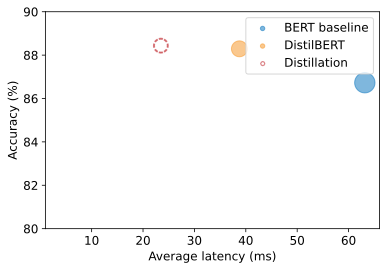

In [52]:
plot_metrics(perf_metrics, optim_type)

## 4. 양자화로 모델 속도 높이기
- 양자화 방식은 계산량을 줄이는 대신 가중치와 활성화 출력을 32비트 부동 소수점이 아닌 8비트 정수 같이 정밀도가 낮은 데이터 타입으로 표현해 계산을 더 효율적으로 수행합니다.
- 비트 수를 줄이면 모델에 필요한 메모리 양이 줄고, 행렬 곱셈 같은 연산이 정수 계산으로 훨씬 빠르게 수행됩니다.
- 놀랍게도 이런 성능향상은 정확도 손실에 미치는 영향이 거의 없습니다. 

- 양자화의 기본 아이디어는 부동 소수점 숫자 f를 이산화할 수 있다는 것이다.
- 원래 범위 [fmax, fmin]에서 고정 소수점 숫자 q로 표현된 작은 범위 [qmax, qmin]으로 매핑하고
- 모든 값을 이 사이에 선형적으로 분포시킵니다. 
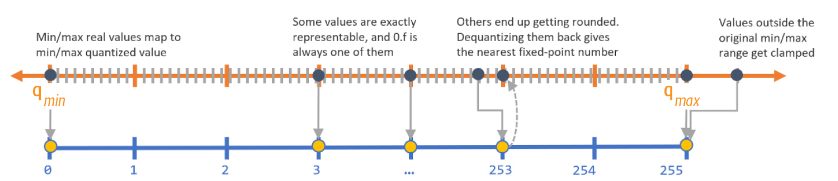


- 트랜스포머가 (그리고 더 일반적으로는 심층 신경망이) 양자화의 주요 후보인 이유는 가중치와 활성화의 값 범위가 비교적 좁기 때문이다.
- FP32 숫자의 전체 범위를 INT8로 표현되는 2^8=256개 숫자로 압축할 필요가 없다는 의미이다.
- 정제 모델의 어텐션 가중치 행렬 중 하나를 선택해 값의 빈도 분포를 그려 확인해보자

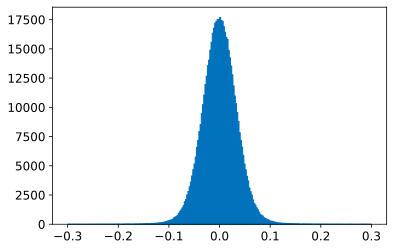

In [53]:
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

- 가중치 값이 원점에 가깝고 범위가 좁은 [-0.1, 0.1] 사이에 분포됐습니다.
- 이 텐서를 부호가 있는 8비트 정수로 압축한다고 해보자
- 이 경우 가능한 정수 범위 [qmax, qmin]=[-128,127]이다.
- 워점 FP32의 원점과 일치하고 스케일링 인자는 이전 공식으로 계산된다.

In [54]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

- 양자화된 텐서를 얻으려면 매핑을 뒤집어 계산하고, 범위 밖의 값을 클리핑하고, 가장 가까운 정수로 반올림하고, Tensor.char() 함수를 사용해 torch.int8 데이터 타입으로 결과를 표현한다.

In [55]:
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -7,   0,  ...,  -6,  -4,   8],
        [  9,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -5,   5,  ...,   1,   5,  -4],
        ...,
        [  5,   0,  13,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

In [56]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -7,   0,  ...,  -6,  -4,   8],
        [  9,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -5,   5,  ...,   1,   5,  -4],
        ...,
        [  5,   0,  13,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

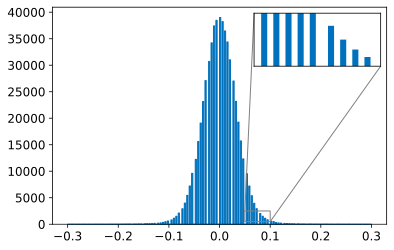

In [57]:
# 트랜스포머 가중치에서 양자화 효과
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

# 히스토그램 그리기
fig, ax = plt.subplots()
ax.hist(quantized_weights.dequantize().flatten().numpy(), 
         bins=250, range=(-0.3,0.3), edgecolor="C0");
# 확대 그림 만들기
axins = zoomed_inset_axes(ax, 5, loc='upper right')
axins.hist(quantized_weights.dequantize().flatten().numpy(), 
         bins=250, range=(-0.3,0.3));
x1, x2, y1, y2 = 0.05, 0.1, 500, 2500
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axes.xaxis.set_visible(False)
axins.axes.yaxis.set_visible(False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.show()

In [58]:
%%timeit 
weights @ weights

5.3 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [59]:
from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [60]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

214 µs ± 3.68 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [61]:
import sys

sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

3.999755879241598

In [62]:

from torch.quantization import quantize_dynamic

# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
model_ckpt = "haesun/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

Downloading:   0%|          | 0.00/360 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/711k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

## 5. 양자화된 모델의 벤치마크 수행하기

In [63]:
pipe = pipeline("text-classification", model=model_quantized, 
                tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 132.39
평균 레이턴시 (ms) - 41.25 +\- 2.51
테스트 세트 정확도 - 0.878


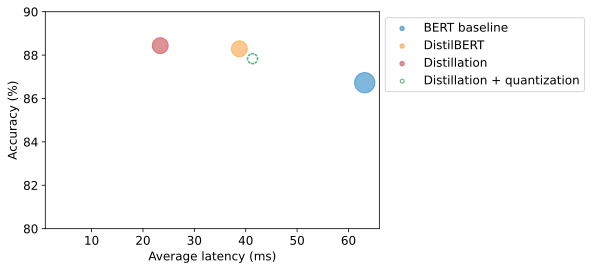

In [64]:
plot_metrics(perf_metrics, optim_type)

In [65]:
import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

In [66]:
from transformers.convert_graph_to_onnx import convert

# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
model_ckpt = "haesun/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer, 
        output=onnx_model_path, opset=12, pipeline_name="text-classification")

/usr/local/lib/python3.8/dist-packages/transformers/convert_graph_to_onnx.py:380: FutureWarning: The `transformers.convert_graph_to_onnx` package is deprecated and will be removed in version 5 of Transformers
  warnings.warn(


ONNX opset version set to: 12
Loading pipeline (model: haesun/distilbert-base-uncased-distilled-clinc, tokenizer: PreTrainedTokenizerFast(name_or_path='haesun/distilbert-base-uncased-distilled-clinc', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}))
Creating folder onnx
Using framework PyTorch: 1.13.1+cu116
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch'}
Ensuring inputs are in correct order
head_mask is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask']


/usr/local/lib/python3.8/dist-packages/transformers/models/distilbert/modeling_distilbert.py:217: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask, torch.tensor(torch.finfo(scores.dtype).min)


In [67]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession, 
                         SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"): 
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

In [68]:
onnx_model = create_model_for_provider(onnx_model_path)

In [69]:
inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

(1, 151)

In [70]:
np.argmax(logits_onnx)

61

In [71]:
clinc_enc["test"][0]["labels"]

61

In [72]:

from scipy.special import softmax

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        
    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy() 
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [73]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

[{'label': 'car_rental', 'score': 0.73602587}]

In [74]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path
        
    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"모델 크기 (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [75]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 255.98
평균 레이턴시 (ms) - 23.13 +\- 1.04
테스트 세트 정확도 - 0.870


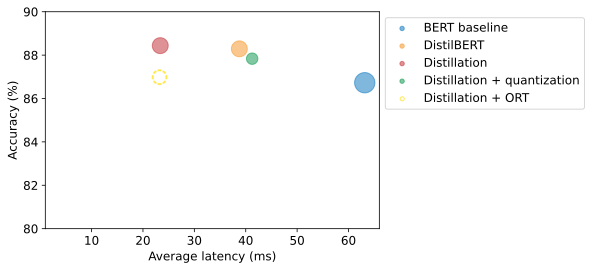

In [76]:
plot_metrics(perf_metrics, optim_type)

In [77]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.5/attention/MatMul]
Ignore MatM

In [78]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type, 
                              model_path=model_output)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 64.33
평균 레이턴시 (ms) - 11.70 +\- 0.52
테스트 세트 정확도 - 0.882


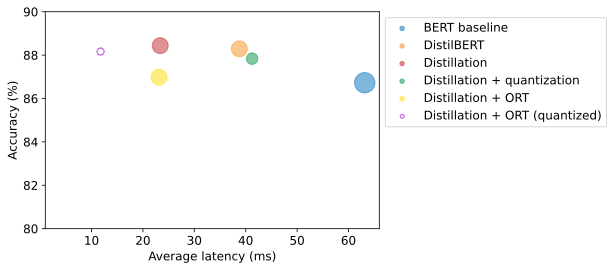

In [79]:
plot_metrics(perf_metrics, optim_type)

## 7. 가중치 가지치기로 희소한 모델 만들기

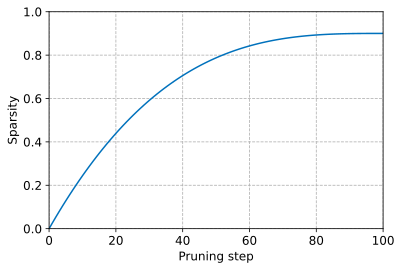

In [80]:
# 가지치기에 사용되는 세제곱 희소성 스케줄러
import numpy as np
import matplotlib.pyplot as plt

def _sparsity(t, t_0=0, dt=1, s_i=0, s_f=0.9, N=100):
    return s_f + (s_i - s_f) * (1 - (t - t_0) / (N * dt))**3

steps = np.linspace(0,100,100)
values = [_sparsity(t) for t in steps]

fig, ax = plt.subplots()
ax.plot(steps, values)
ax.set_ylim(0,1)
ax.set_xlim(0,100)
ax.set_xlabel("Pruning step")
ax.set_ylabel("Sparsity")
plt.grid(linestyle="dashed")
plt.show()